In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, csr_matrix
from scipy.sparse.csgraph import connected_components, shortest_path
import requests
import zipfile
import io
import os
import random
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigsh

In [ ]:
DATA_URL = "https://networksciencebook.com/translations/en/resources/networks.zip"
DATA_DIR = "data"

def download_datasets():
    os.makedirs(DATA_DIR, exist_ok=True)
    zip_path = os.path.join(DATA_DIR, "networks.zip")

    resp = requests.get(DATA_URL, timeout=30)
    resp.raise_for_status()

    with open(zip_path, "wb") as f:
        f.write(resp.content)

    # basic sanity check and extraction
    if not resp.content[:2] == b"PK":
        raise RuntimeError(f"Downloaded file does not look like a ZIP (first bytes: {resp.content[:32]!r})")

    with zipfile.ZipFile(zip_path) as z:
        z.extractall(DATA_DIR)

#download_datasets()

# Question 1a

In [ ]:
def load_edge_list(file_path):
    edges = np.loadtxt(file_path, dtype=int)
    return edges

def undirected_adj(edges):
    if edges.min() == 1: edges = edges - 1
    edges = edges[edges[:, 0] != edges[:, 1]]
    edges = np.sort(edges, axis=1)
    edges = np.unique(edges, axis=0)
    num_nodes = edges.max() + 1
    
    A = csc_matrix((np.ones(len(edges)), (edges[:, 0], edges[:, 1])), shape=(num_nodes, num_nodes))
    A = A + A.T
    return A

def metrics(adj_matrix):
    num_components, labels = connected_components(adj_matrix, directed=False)

    component_sizes = np.bincount(labels)
    largest_component_size = component_sizes.max()

    num_nodes = adj_matrix.shape[0]
    num_edges = adj_matrix.nnz // 2

    return {
        "Number of Nodes": int(num_nodes),
        "Number of Edges": int(num_edges),
        "Number of Components": int(num_components),
        "Largest Component Size": int(largest_component_size),
    }

edges = load_edge_list("data/metabolic.edgelist.txt")
A = undirected_adj(edges)
graph_metrics = metrics(A)

print(graph_metrics)

# Question 1b

In [ ]:
def degree_dist(adj_matrix):
	# degree for undirected graph
	degrees = np.asarray(adj_matrix.sum(axis=1)).ravel().astype(int)

	# occurrences of each degree
	degree_values, degree_counts = np.unique(degrees, return_counts=True)

	return degree_values, degree_counts

def fit_power_law(degree_values, degree_counts, kmin=1):
	mask = (degree_values >= kmin) & (degree_values > 0) & (degree_counts > 0)
	x = degree_values[mask]
	y = degree_counts[mask]

	if len(x) < 2:
		raise ValueError("Not enough data points to fit a power law. Try lowering kmin.")

	log_x = np.log(x)
	log_y = np.log(y)

	slope, intercept = np.polyfit(log_x, log_y, 1)
	return slope, intercept

def degree_dist_plot(degree_values, degree_counts, slope, intercept):
	plt.figure(figsize=(8, 6))

	# degree distribution
	plt.scatter(degree_values, degree_counts, label="Degree Distribution", alpha=0.6)

	# fitted power law line
	log_degrees = np.log(degree_values[degree_values > 0])
	fitted_line = np.exp(intercept + slope * log_degrees)
	plt.plot(degree_values[degree_values > 0], fitted_line, label=f"Power-law Fit (slope={slope:.2f})")

	plt.xscale("log")
	plt.yscale("log")
	plt.xlabel("Degree k")
	plt.ylabel("Count")
	plt.title("Degree Distribution (log-log) with Power-law Fit")
	plt.legend()
	plt.grid(True, which="both", linestyle="--", linewidth=0.5)
	plt.tight_layout()
	plt.show()

degree_values, degree_counts = degree_dist(A)
slope, intercept = fit_power_law(degree_values, degree_counts, kmin=1)
print(f"Power-law fit slope (log(count) vs log(k)): {slope:.4f}")
degree_dist_plot(degree_values, degree_counts, slope, intercept)

# Question 1c

Average shortest path length (reachable pairs only, sampled): 2.1830


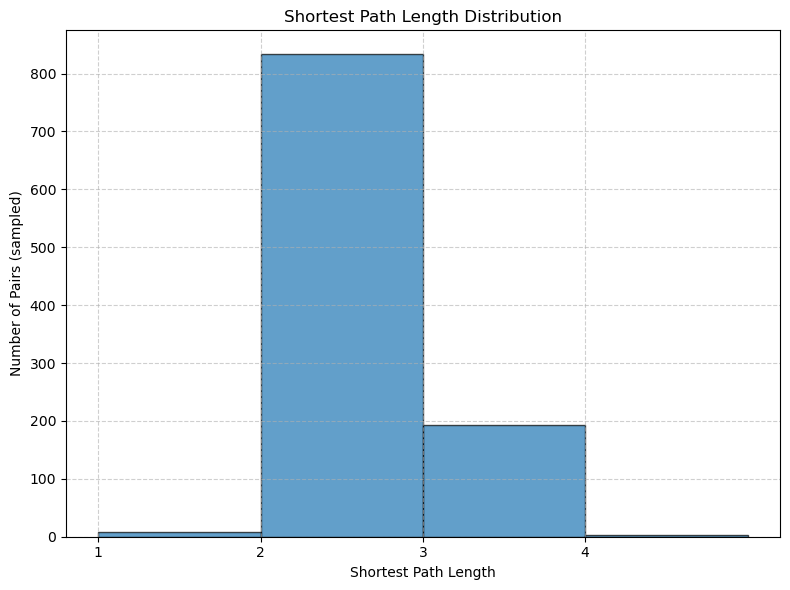

In [ ]:
def shortest_paths_dist(adj_matrix, sample_fraction=0.01, seed=0):
    rng = random.Random(seed)
    A = adj_matrix

    num_nodes = int(A.shape[0])
    if num_nodes == 0: return [], float("nan")

    num_sample_nodes = max(1, int(sample_fraction * num_nodes))
    num_sample_nodes = min(num_sample_nodes, num_nodes)

    sampled_nodes = rng.sample(range(num_nodes), num_sample_nodes)
    sampled_distances = []

    for node in sampled_nodes:
        dist_vector = shortest_path(csgraph=A, directed=False, indices=node, unweighted=True)
        finite = dist_vector[np.isfinite(dist_vector)]
        finite = finite[finite > 0]  # drop self-distance 0
        if finite.size:
            sampled_distances.extend(finite.astype(int).tolist())

    avg_shortest_path = float(np.mean(sampled_distances)) if sampled_distances else float("nan")

    return sampled_distances, avg_shortest_path

def shortest_paths_dist_bar(path_lengths):
    if not path_lengths:
        print("No path lengths to plot.")
        return

    path_lengths = np.asarray(path_lengths, dtype=int)
    path_lengths = path_lengths[path_lengths > 0]

    if path_lengths.size == 0:
        print("No positive path lengths to plot.")
        return

    max_len = int(path_lengths.max())
    bins = np.arange(1, max_len + 2)  # [1, 2, ..., max_len+1]

    hist, bin_edges = np.histogram(path_lengths, bins=bins)
    centers = bin_edges[:-1]

    plt.figure(figsize=(8, 6))
    plt.bar(centers, hist, width=1.0, edgecolor="black", alpha=0.7, align="edge")

    plt.xlabel("Shortest Path Length")
    plt.ylabel("Number of Pairs (sampled)")
    plt.title("Shortest Path Length Distribution")
    plt.xticks(range(1, max_len + 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

path_lengths, avg_sp = shortest_paths_dist(A, sample_fraction=0.001, seed=0)
print(f"Average shortest path length (reachable pairs only, sampled): {avg_sp:.4f}")
shortest_paths_dist_bar(path_lengths)

# Question 1d

avg: 0.403452380952381


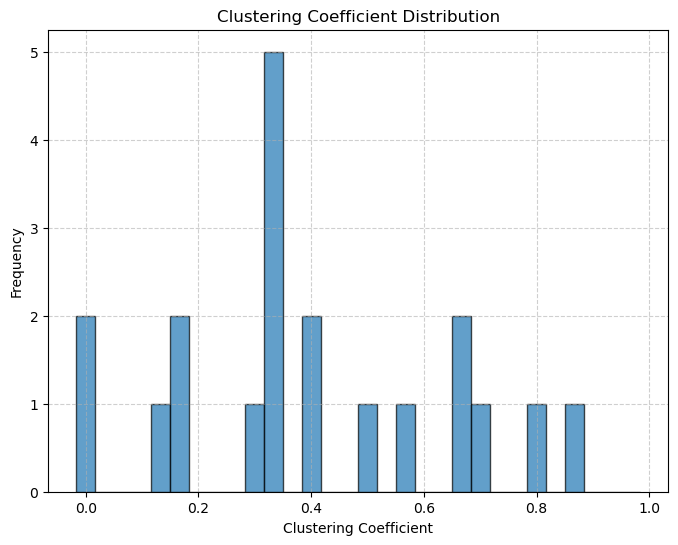

In [ ]:
def compute_local_clustering(adj_matrix, sample_fraction=1.0):
    # CSR format
    adj_matrix = adj_matrix.tocsr()
    num_nodes = adj_matrix.shape[0]

    # sample nodes
    if sample_fraction < 1.0:
        sampled_nodes = random.sample(
            range(num_nodes),
            int(sample_fraction * num_nodes)
        )
    else:
        sampled_nodes = range(num_nodes)

    clustering_coeffs = []

    for node in sampled_nodes:
        neighbors = adj_matrix[node].indices
        k = len(neighbors)

        if k < 2:
            clustering_coeffs.append(0.0)
            continue

        # induced subgraph on neighbors
        subgraph = adj_matrix[neighbors, :][:, neighbors]
        num_edges = subgraph.nnz // 2

        # max possible number of edges between neighbors
        possible_edges = k * (k - 1) // 2
        # clustering coefficient for the current node
        clustering_coeffs.append(num_edges / possible_edges)

    avg_clustering = np.mean(clustering_coeffs)
    return clustering_coeffs, avg_clustering

def clustering_dist_bar(clustering_coeffs, bins=10):
    hist, bin_edges = np.histogram(clustering_coeffs, bins=bins, range=(0, 1), density=False)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], hist, width=(bin_edges[1] - bin_edges[0]), edgecolor="black", alpha=0.7)
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Frequency")
    plt.title("Clustering Coefficient Distribution")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

coeffs, avg = compute_local_clustering(A, sample_fraction=0.02)
print("avg:", avg)
clustering_dist_bar(coeffs, bins=30)

# Question 1e

Spectral gap (|λ1| - |λ2|): 10.053713


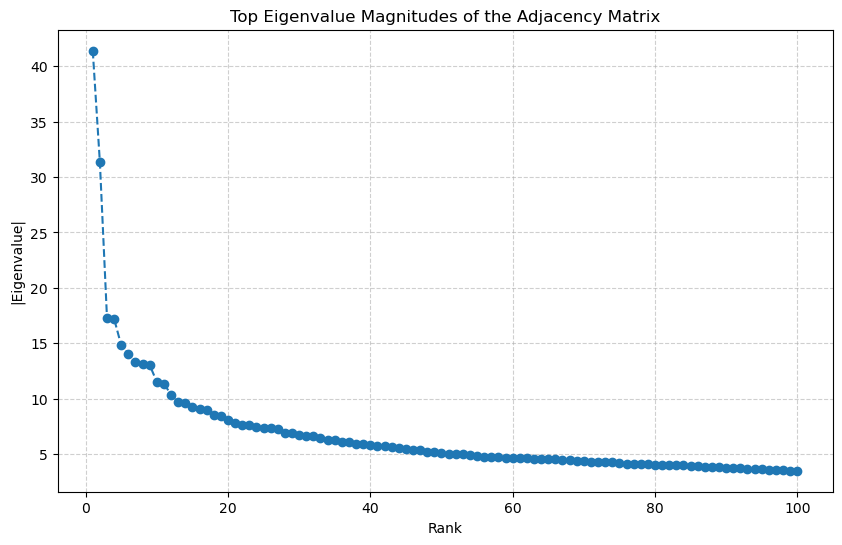

In [ ]:
def eigenvalues(adj_matrix, num_eigenvalues=100):
    eigvals = eigsh(adj_matrix, k=num_eigenvalues, which="LM", return_eigenvectors=False)
    eigvals_abs = np.sort(np.abs(eigvals))[::-1]
    spectral_gap = eigvals_abs[0] - eigvals_abs[1]
    return eigvals_abs, spectral_gap

def eigenvalues_plot(eigvals_abs):
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(eigvals_abs) + 1),
        eigvals_abs,
        marker="o",
        linestyle="--",
    )
    plt.xlabel("Rank")
    plt.ylabel("|Eigenvalue|")
    plt.title("Top Eigenvalue Magnitudes of the Adjacency Matrix")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

eigvals_abs, spectral_gap = eigenvalues(A, num_eigenvalues=100)
print(f"Spectral gap: {spectral_gap:.6f}")
eigenvalues_plot(eigvals_abs)

# Question 1f

Degree correlation (Pearson): -0.25033246294814865


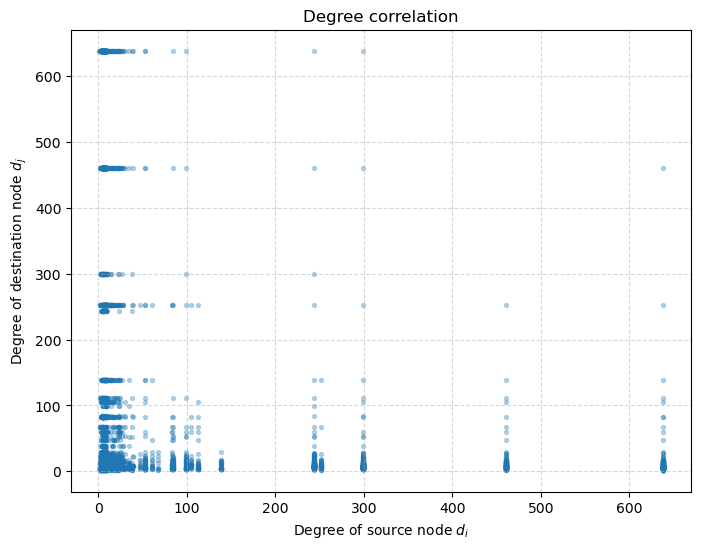

In [ ]:
def degrees(adj_matrix):
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    return degrees

def degree_corr(adj_matrix, degrees):
    rows, cols = adj_matrix.nonzero()
    # keep each undirected edge once
    di_dj_pairs = [(degrees[u], degrees[v]) for u, v in zip(rows, cols) if u < v]
    di, dj = zip(*di_dj_pairs)

    corr_matrix = np.corrcoef(di, dj)
    correlation = corr_matrix[0, 1]

    return di_dj_pairs, correlation

def degree_corr_plot(di_dj_pairs):
    di, dj = zip(*di_dj_pairs)
    plt.figure(figsize=(8, 6))
    plt.scatter(di, dj, s=8, alpha=0.3)
    plt.xlabel("Degree of source node $d_i$")
    plt.ylabel("Degree of destination node $d_j$")
    plt.title("Degree correlation")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

degrees = degrees(A)
pairs, corr = degree_corr(A, degrees)
print("Degree correlation (Pearson):", corr)
degree_corr_plot(pairs)

# Question 1g

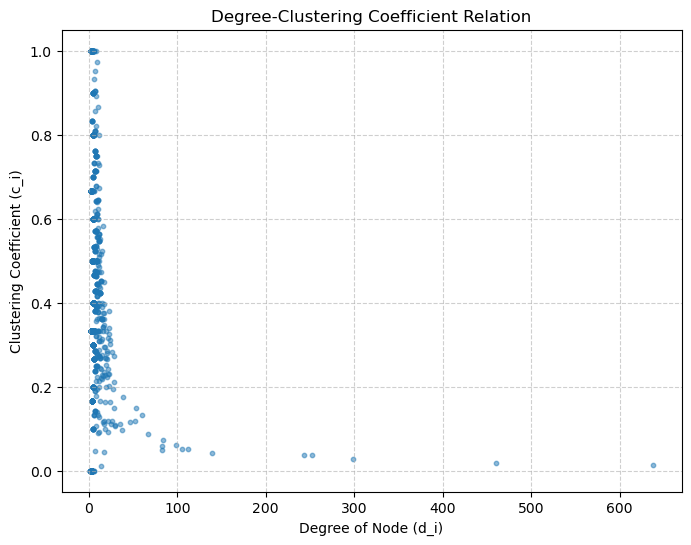

In [ ]:

def degrees(adj_matrix):
    degrees = np.array(adj_matrix.sum(axis=0)).flatten()
    return degrees

def clustering_coeffs(adj_matrix):
    adj_matrix = adj_matrix.tocsr()
    num_nodes = adj_matrix.shape[0]
    clustering_coeffs = {}

    for node in range(num_nodes):
        neighbors = adj_matrix[node].indices
        degree = len(neighbors)

        if degree < 2:
            clustering_coeffs[node] = 0.0
            continue

        subgraph = adj_matrix[neighbors, :][:, neighbors]
        edges_among_neighbors = subgraph.nnz // 2
        possible_edges = degree * (degree - 1) // 2
        clustering_coeffs[node] = edges_among_neighbors / possible_edges

    return clustering_coeffs

def degree_clustering_relation(degrees, clustering_coeffs):
    clustering_array = np.array([clustering_coeffs[node] for node in range(len(degrees))])

    plt.figure(figsize=(8, 6))
    plt.scatter(degrees, clustering_array, alpha=0.5, s=10)
    plt.xlabel("Degree of Node (d_i)")
    plt.ylabel("Clustering Coefficient (c_i)")
    plt.title("Degree-Clustering Coefficient Relation")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

degrees = degrees(A)
clustering_coeffs = clustering_coeffs(A)
degree_clustering_relation(degrees, clustering_coeffs)

# Question 3


######################################################################
DATASET: Metabolic (data/metabolic.edgelist.txt)
Matched BA params from real graph: n=1039, E=4741, m≈E/n=5

Metabolic REAL

(a) Graph metrics
Number of Nodes: 1039
Number of Edges: 4741
Number of Components: 1
Largest Component Size: 1039

(b) Degree distribution + power-law fit
Slope (log count vs log k): -0.9842


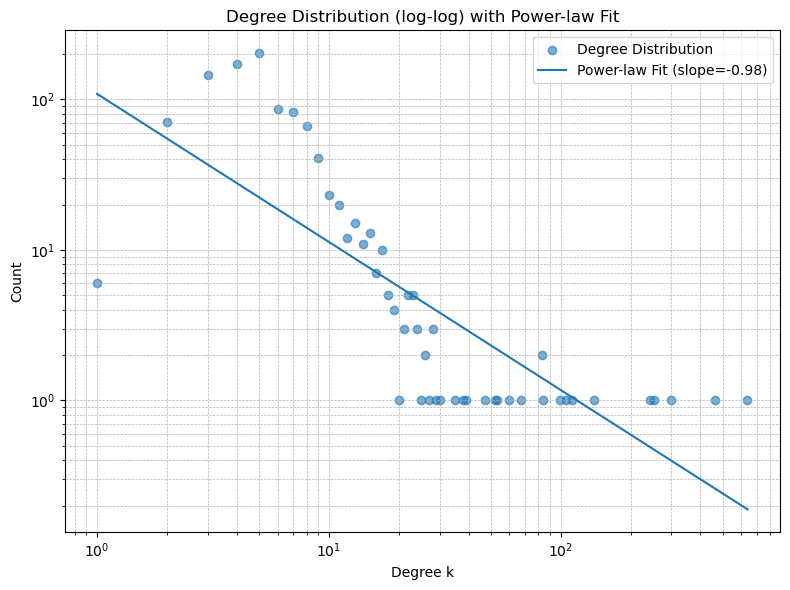


(c) Shortest path length distribution (sampled)
Average shortest path length (reachable pairs only, sampled): 2.6250


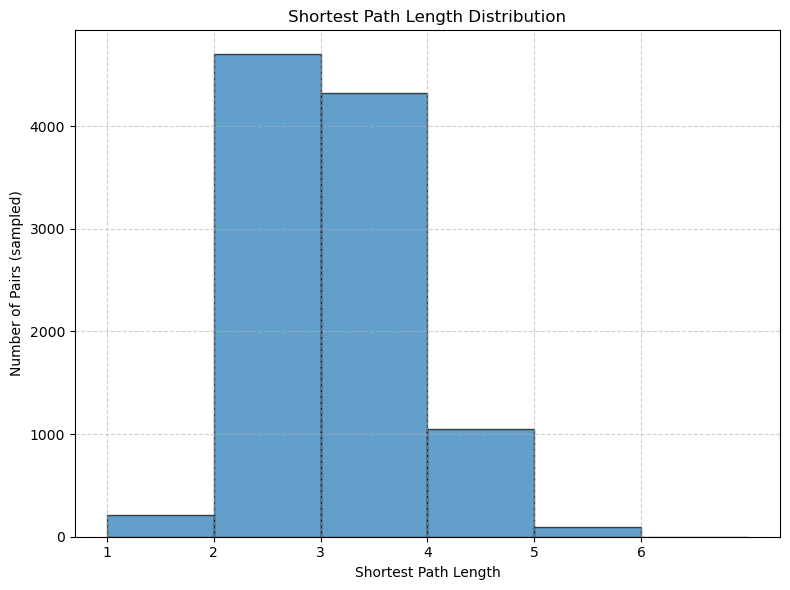


(d) Clustering coefficient distribution (sampled)
Average clustering coefficient (sampled): 0.4214


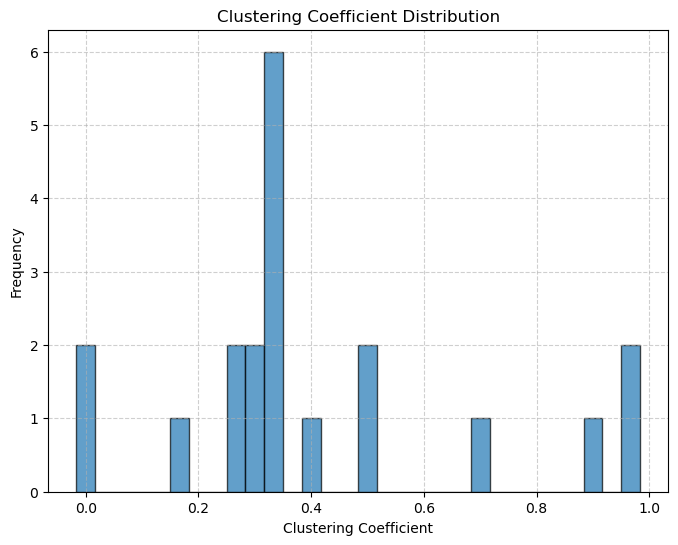


(e) Eigenvalue spectrum + spectral gap
Spectral gap (|λ1| - |λ2|): 10.053713


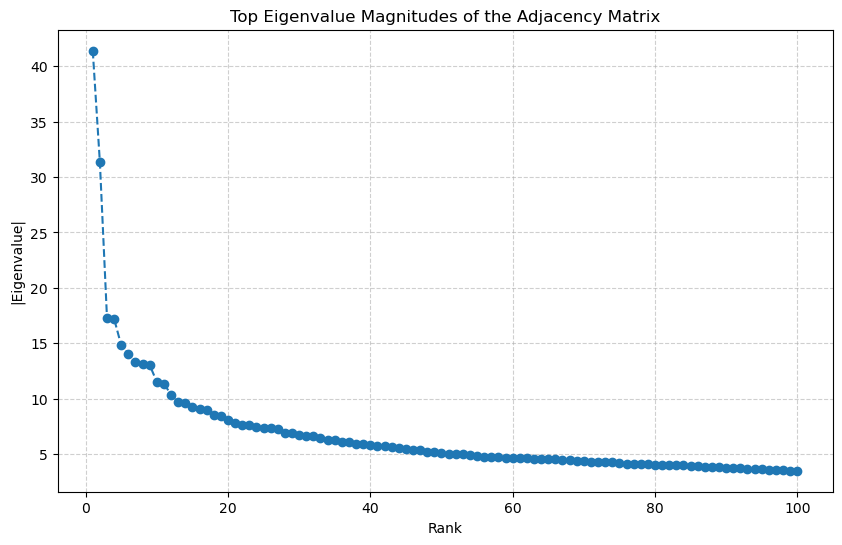


(f) Degree correlations
Degree correlation (Pearson): -0.25033246294814865


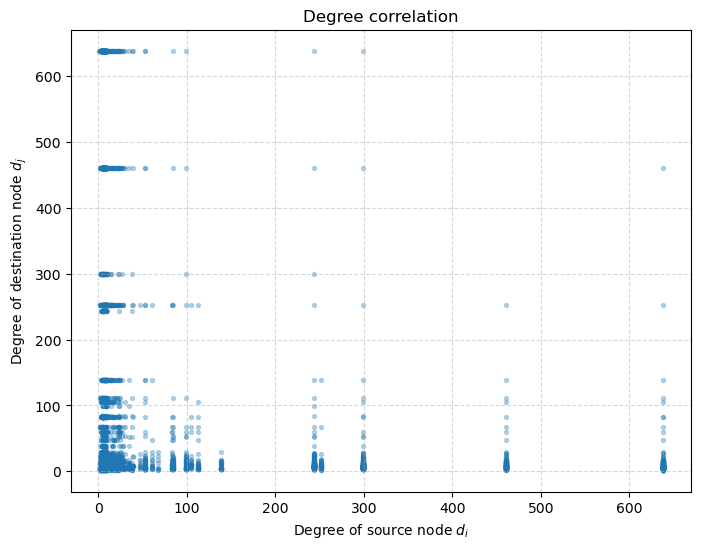


(g) Degree vs clustering coefficient


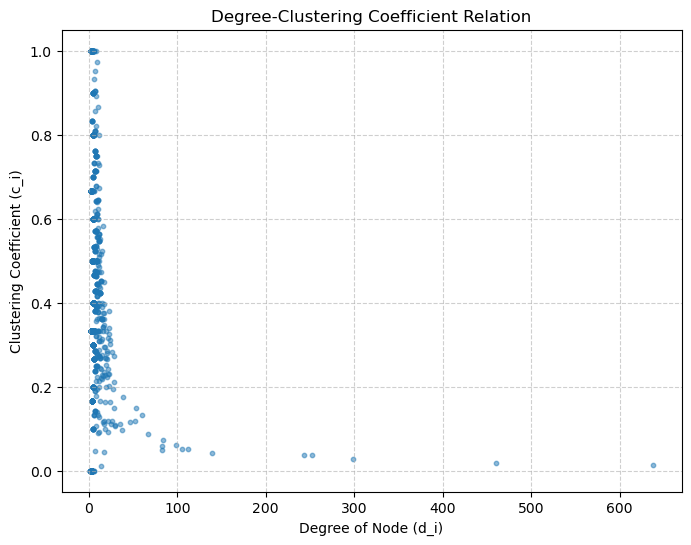

[INFO] Generating AB graph with n=1039, m=5...
[INFO] AB graph adjacency matrix built successfully!

Metabolic BA SYNTHETIC (n=1039, m=5)

(a) Graph metrics
Number of Nodes: 1039
Number of Edges: 5180
Number of Components: 1
Largest Component Size: 1039

(b) Degree distribution + power-law fit
Slope (log count vs log k): -1.8498


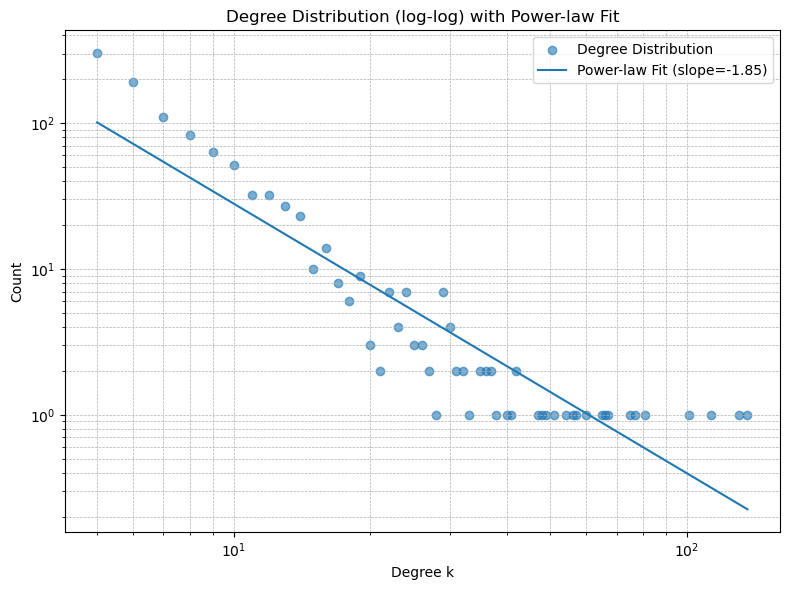


(c) Shortest path length distribution (sampled)
Average shortest path length (reachable pairs only, sampled): 3.0954


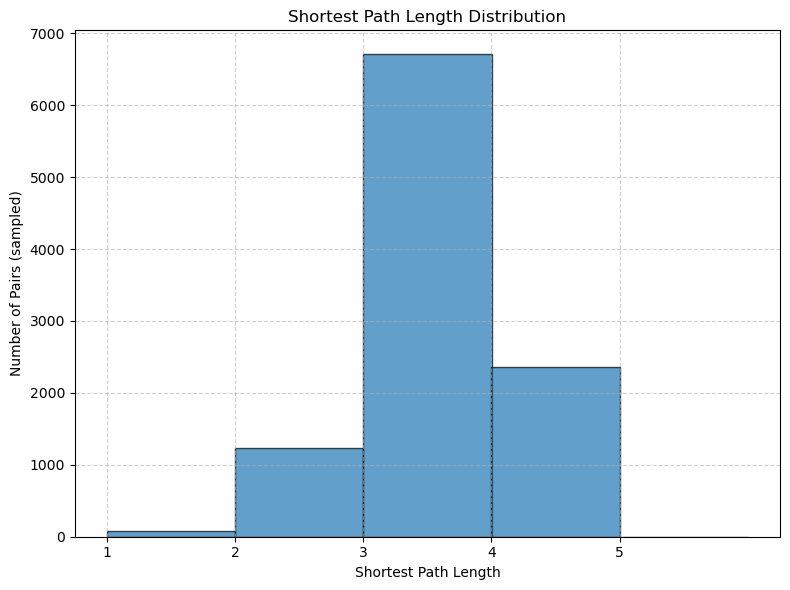


(d) Clustering coefficient distribution (sampled)
Average clustering coefficient (sampled): 0.0383


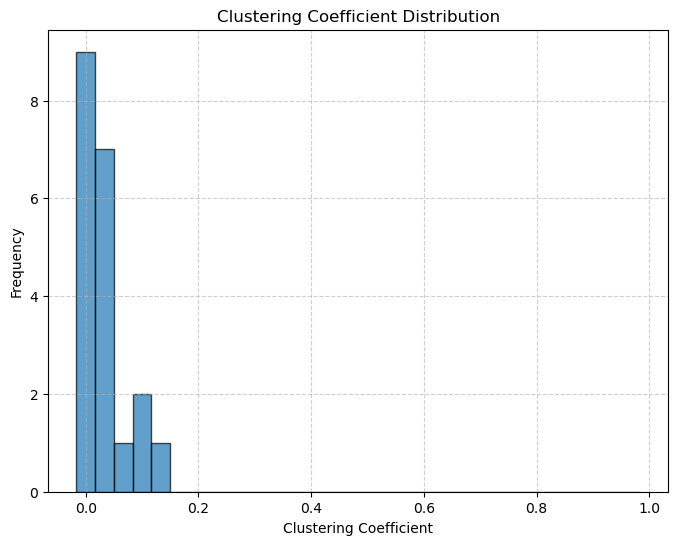


(e) Eigenvalue spectrum + spectral gap
Spectral gap (|λ1| - |λ2|): 9.538181


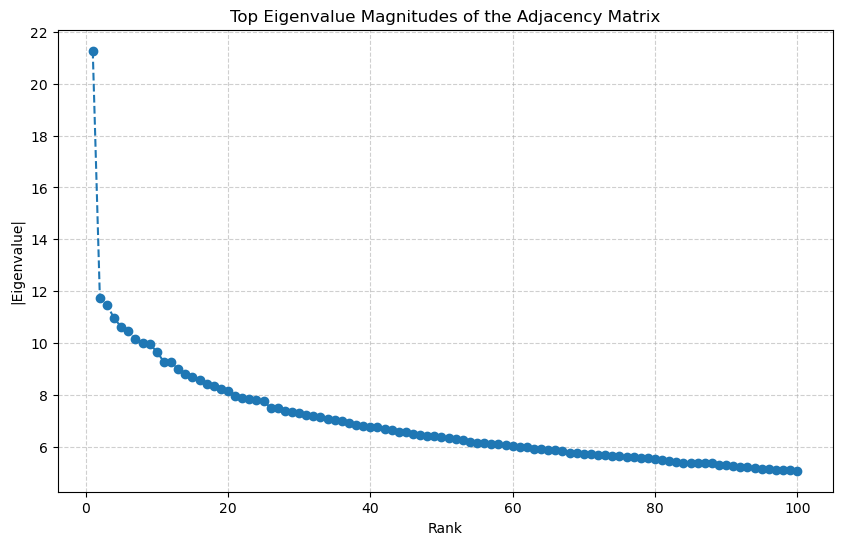


(f) Degree correlations
Degree correlation (Pearson): 0.3117793687984829


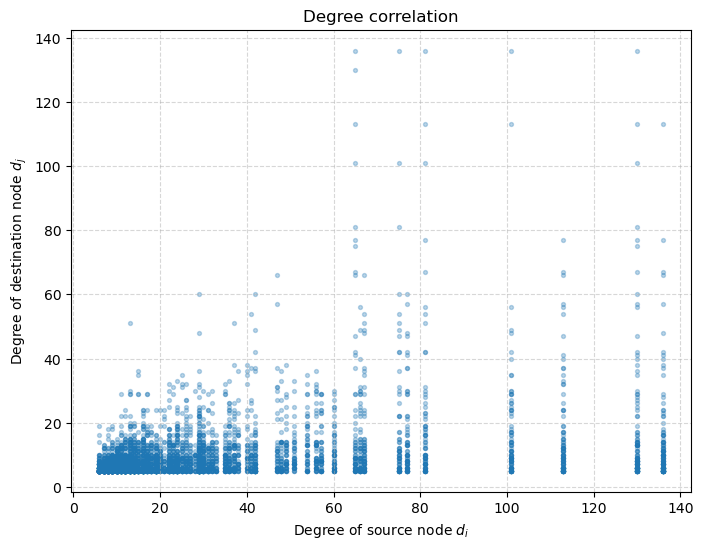


(g) Degree vs clustering coefficient


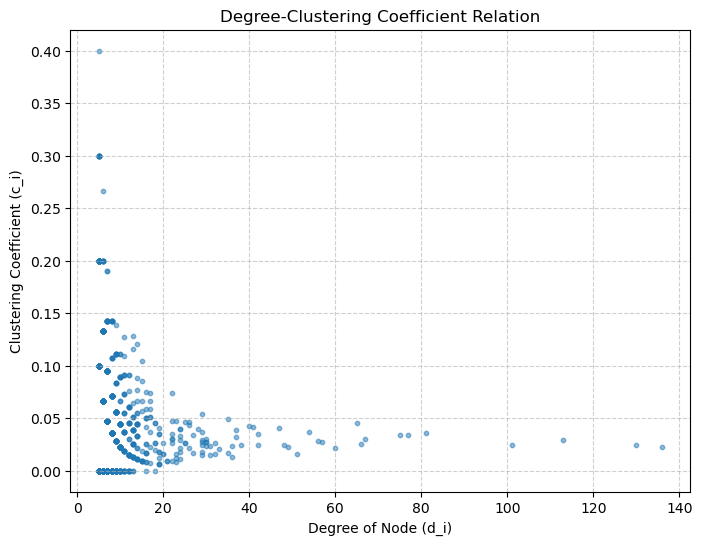


######################################################################
DATASET: Internet (data/internet.edgelist.txt)
Matched BA params from real graph: n=192244, E=609066, m≈E/n=3

Internet REAL

(a) Graph metrics
Number of Nodes: 192244
Number of Edges: 609066
Number of Components: 308
Largest Component Size: 190914

(b) Degree distribution + power-law fit
Slope (log count vs log k): -2.1490


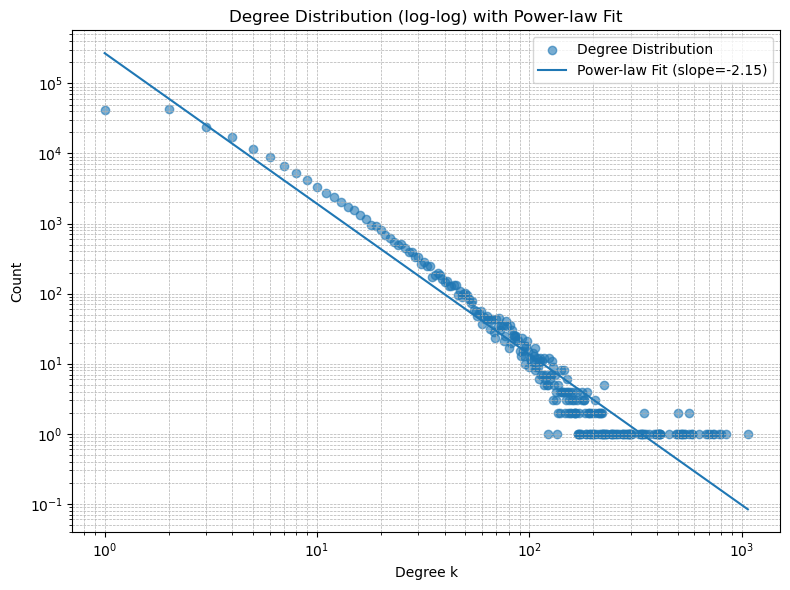


(c) Shortest path length distribution (sampled)
Average shortest path length (reachable pairs only, sampled): 7.0765


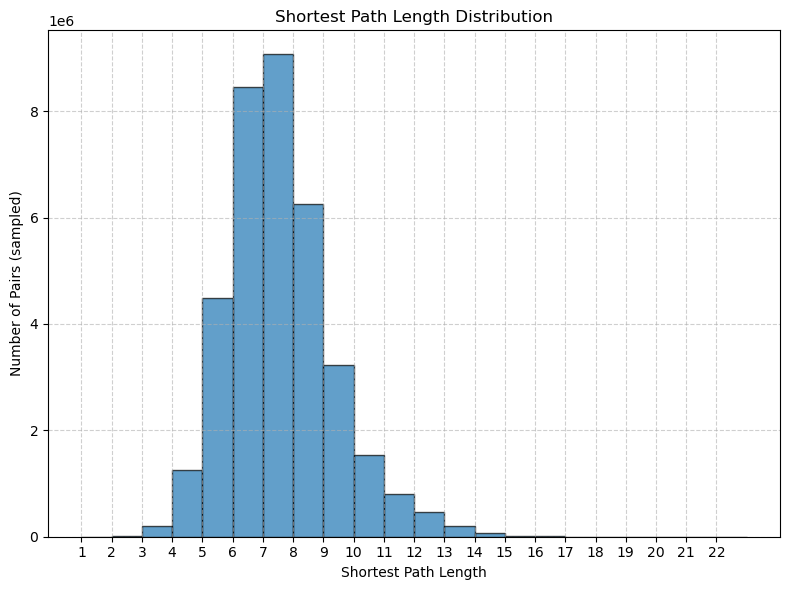


(d) Clustering coefficient distribution (sampled)
Average clustering coefficient (sampled): 0.1383


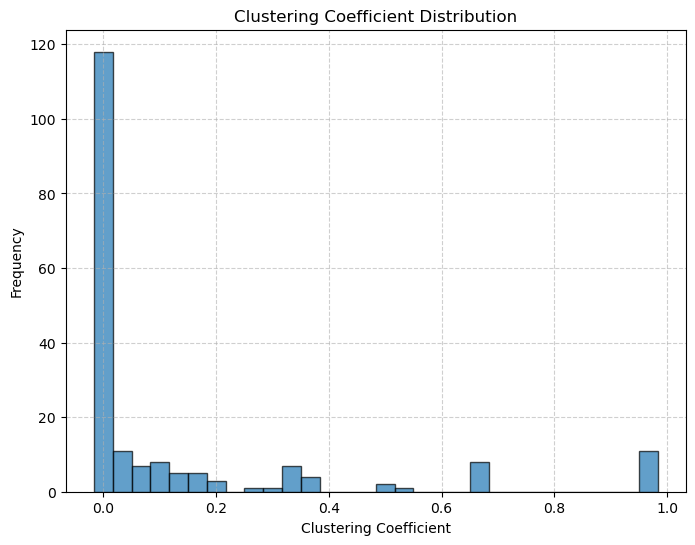


(e) Eigenvalue spectrum + spectral gap
Spectral gap (|λ1| - |λ2|): 1.367081


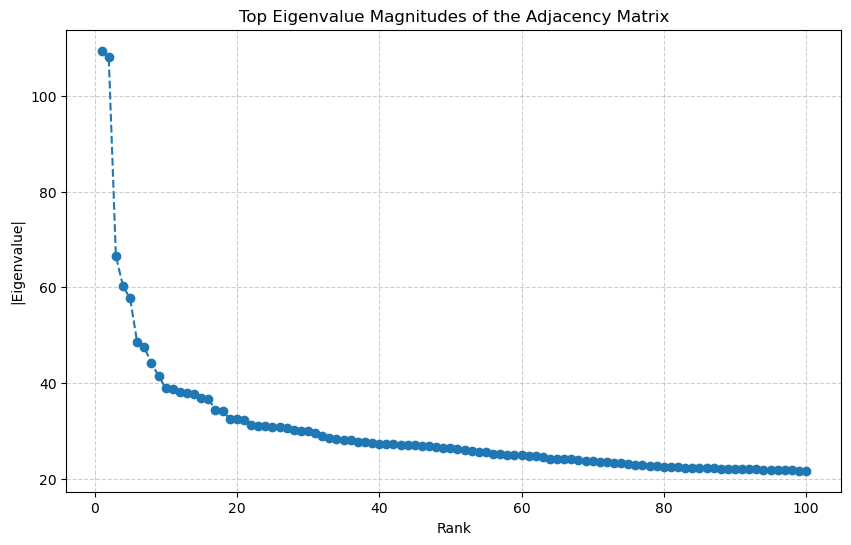


(f) Degree correlations
Degree correlation (Pearson): 0.09763518758962589


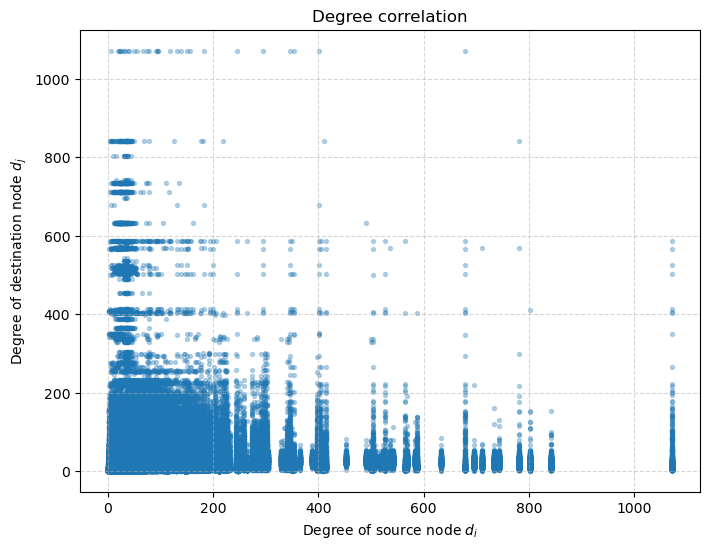


(g) Degree vs clustering coefficient


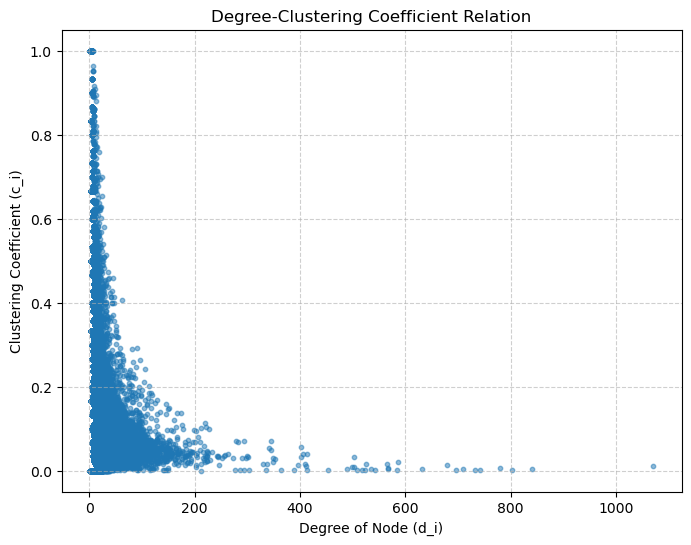

[INFO] Generating AB graph with n=192244, m=3...
[INFO] AB graph adjacency matrix built successfully!

Internet BA SYNTHETIC (n=192244, m=3)

(a) Graph metrics
Number of Nodes: 192244
Number of Edges: 576726
Number of Components: 1
Largest Component Size: 192244

(b) Degree distribution + power-law fit
Slope (log count vs log k): -2.1310


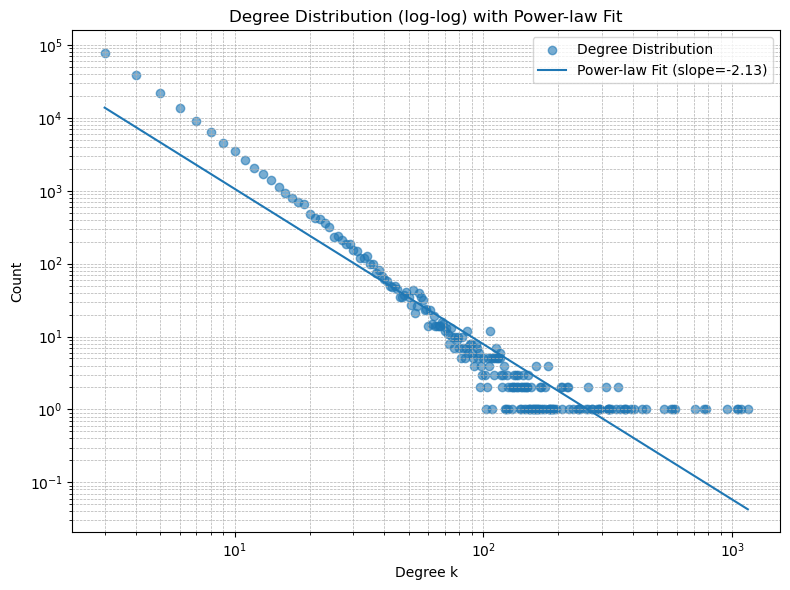


(c) Shortest path length distribution (sampled)
Average shortest path length (reachable pairs only, sampled): 5.2197


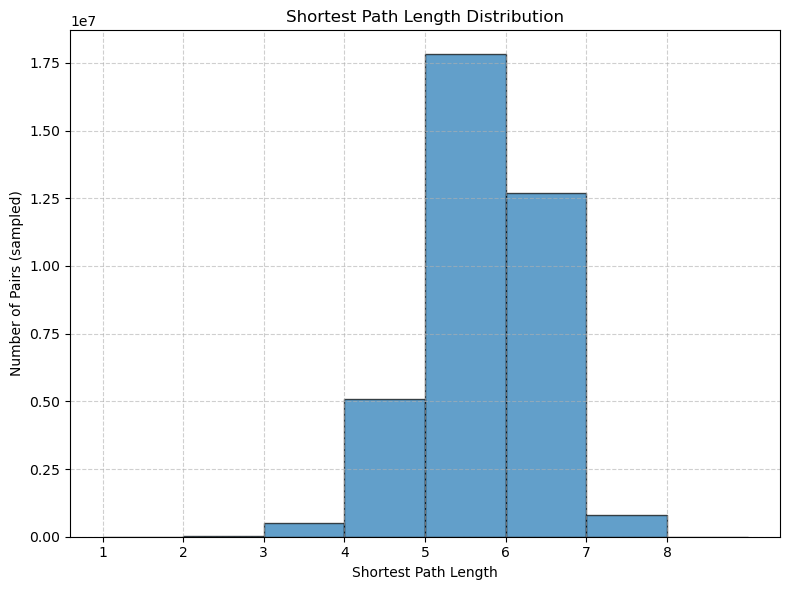


(d) Clustering coefficient distribution (sampled)
Average clustering coefficient (sampled): 0.0026


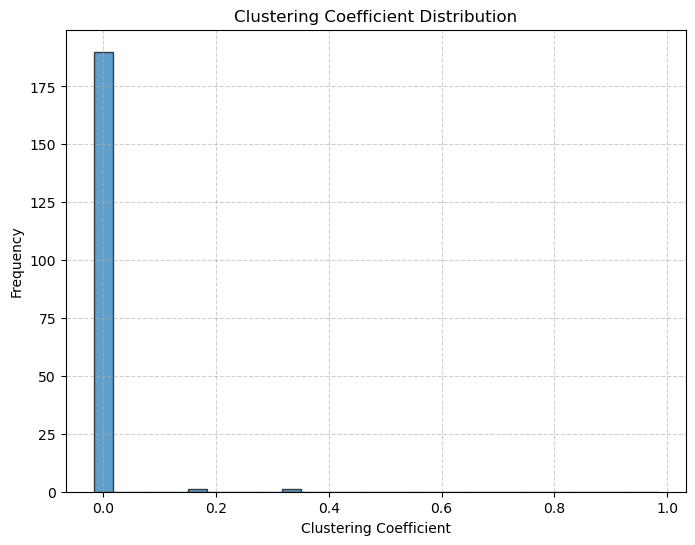


(e) Eigenvalue spectrum + spectral gap
Spectral gap (|λ1| - |λ2|): 1.846065


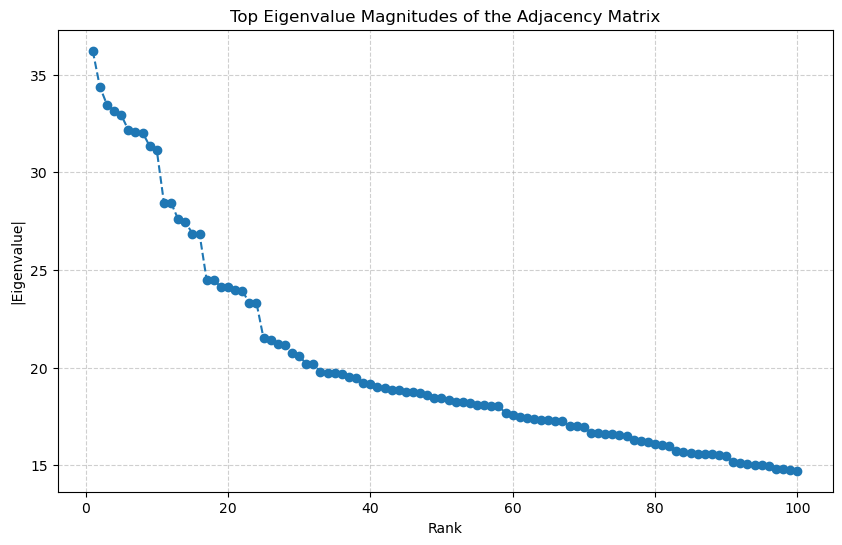


(f) Degree correlations
Degree correlation (Pearson): 0.18789465188785534


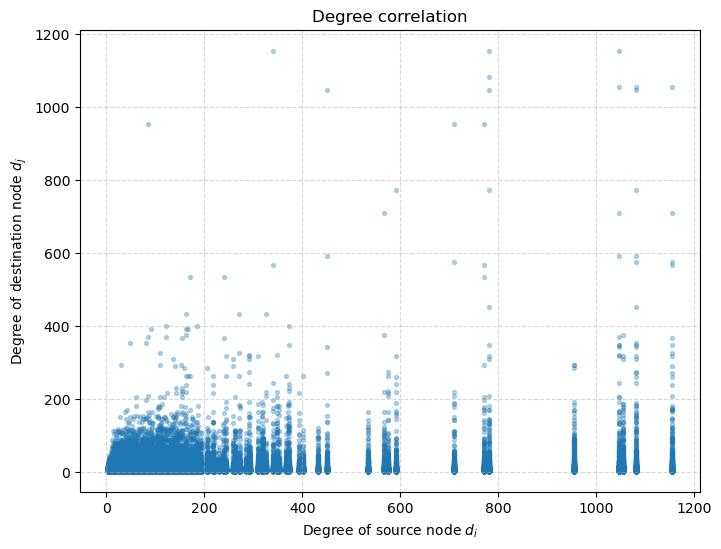


(g) Degree vs clustering coefficient


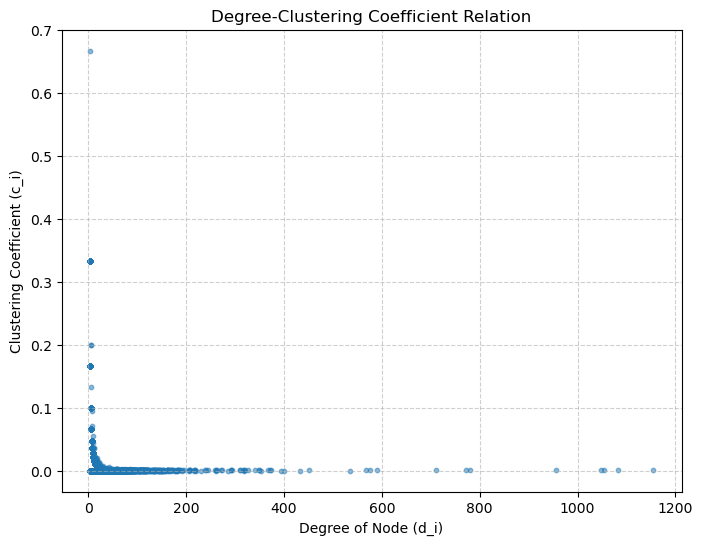


######################################################################
DATASET: Power Grid (data/powergrid.edgelist.txt)
Matched BA params from real graph: n=4941, E=6594, m≈E/n=1

Power Grid REAL

(a) Graph metrics
Number of Nodes: 4941
Number of Edges: 6594
Number of Components: 1
Largest Component Size: 4941

(b) Degree distribution + power-law fit
Slope (log count vs log k): -2.8445


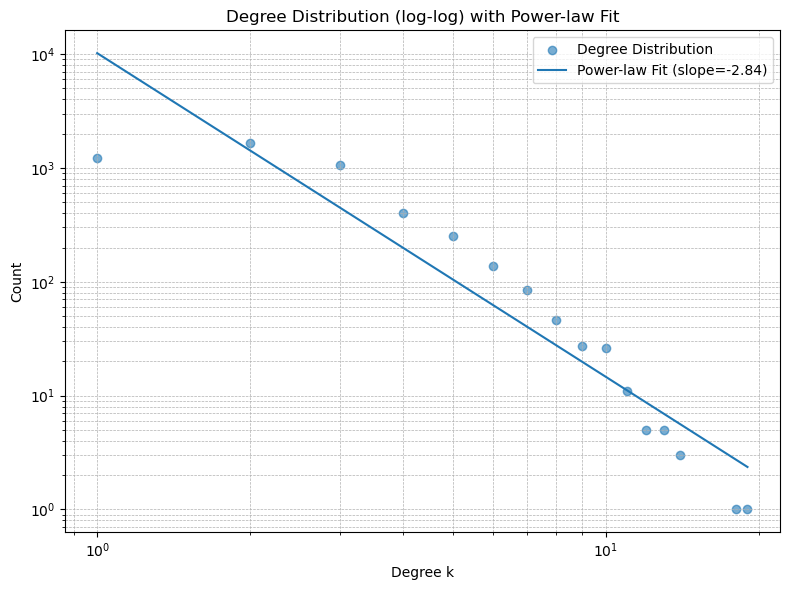


(c) Shortest path length distribution (sampled)
Average shortest path length (reachable pairs only, sampled): 19.2526


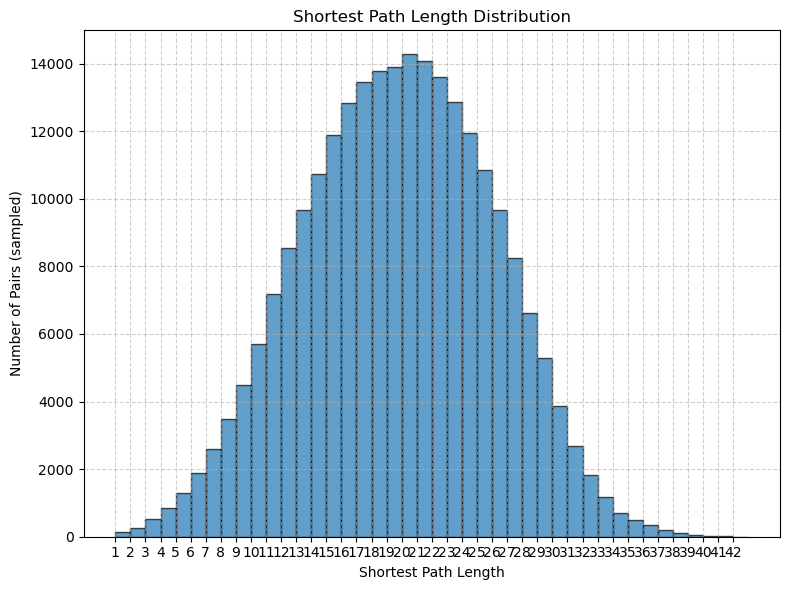


(d) Clustering coefficient distribution (sampled)
Average clustering coefficient (sampled): 0.0577


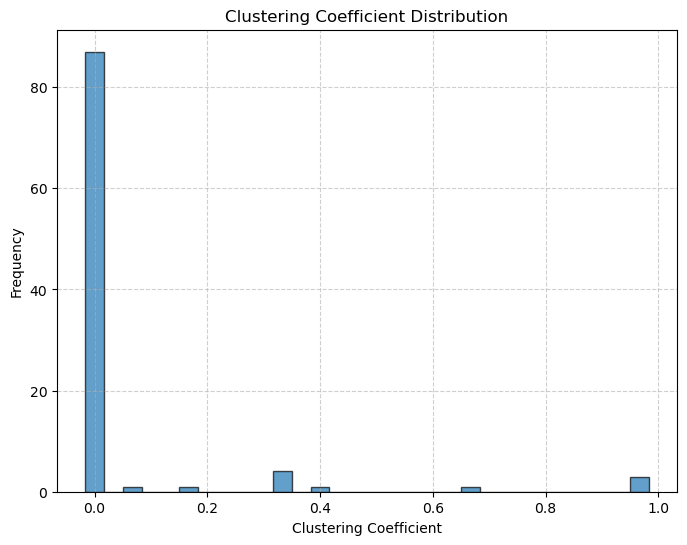


(e) Eigenvalue spectrum + spectral gap
Spectral gap (|λ1| - |λ2|): 0.873806


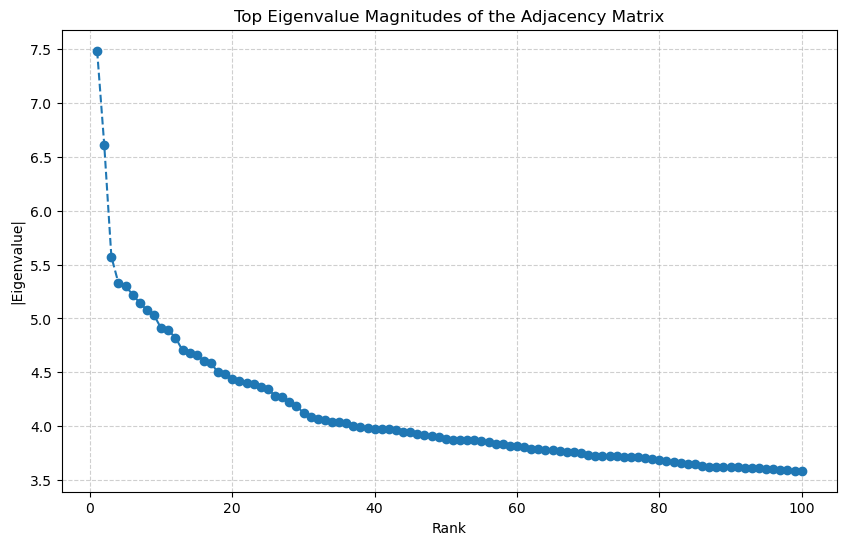


(f) Degree correlations
Degree correlation (Pearson): 0.024134280380011756


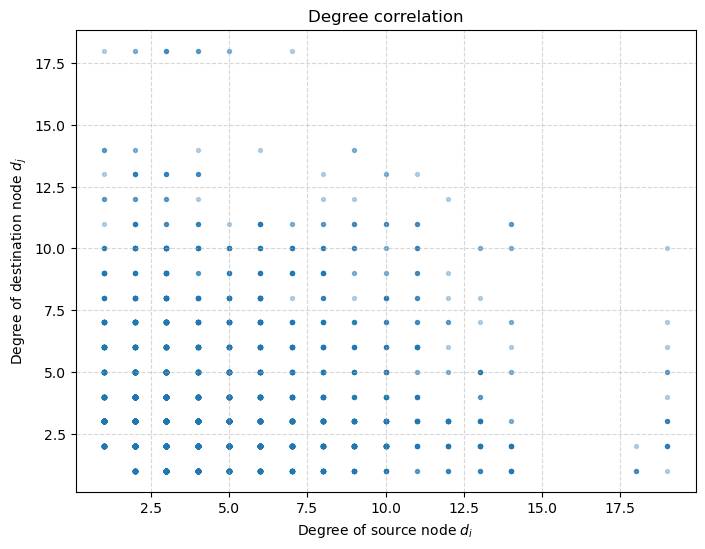


(g) Degree vs clustering coefficient


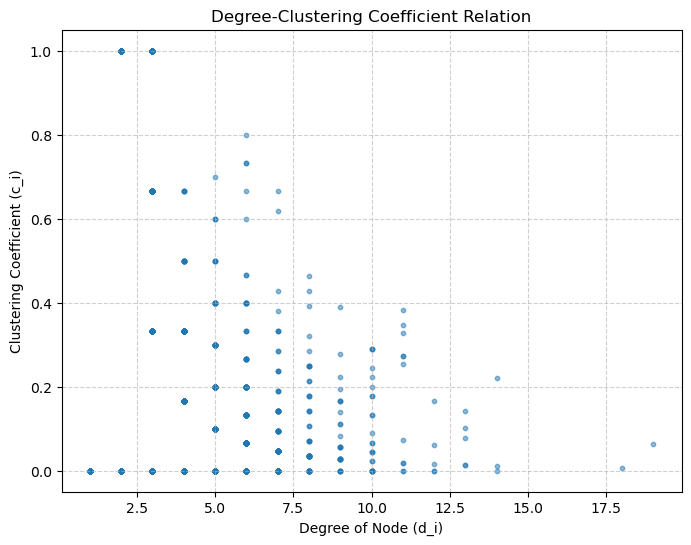

[INFO] Generating AB graph with n=4941, m=1...
[INFO] AB graph adjacency matrix built successfully!

Power Grid BA SYNTHETIC (n=4941, m=1)

(a) Graph metrics
Number of Nodes: 4941
Number of Edges: 4940
Number of Components: 1
Largest Component Size: 4941

(b) Degree distribution + power-law fit
Slope (log count vs log k): -1.8576


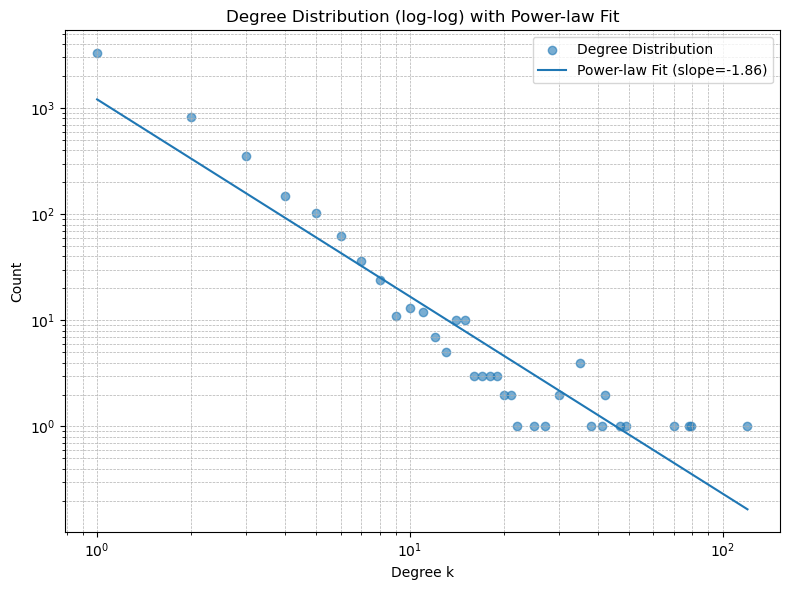


(c) Shortest path length distribution (sampled)
Average shortest path length (reachable pairs only, sampled): 8.8914


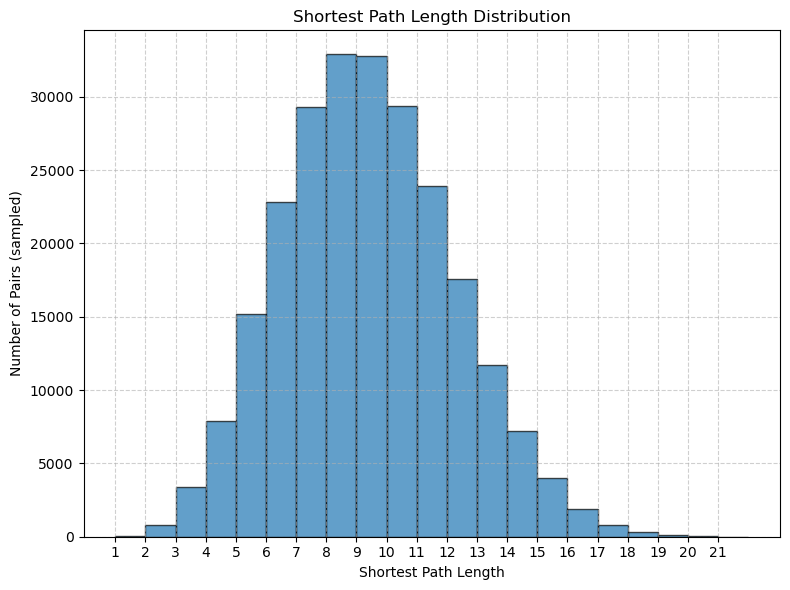


(d) Clustering coefficient distribution (sampled)
Average clustering coefficient (sampled): 0.0000


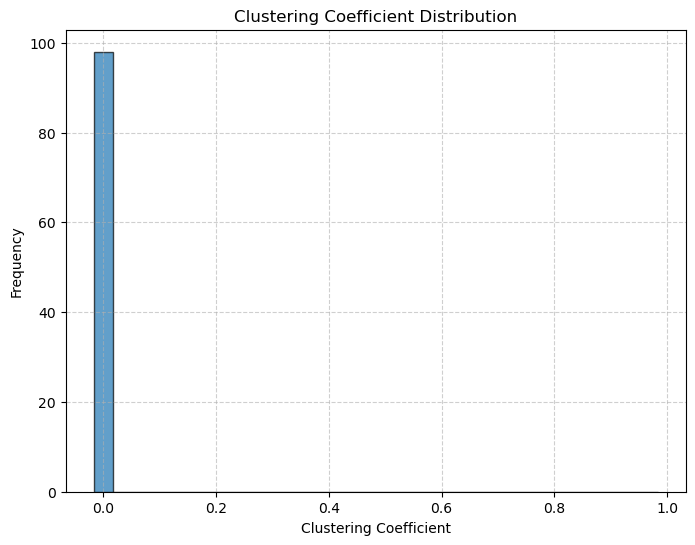


(e) Eigenvalue spectrum + spectral gap
Spectral gap (|λ1| - |λ2|): 0.000000


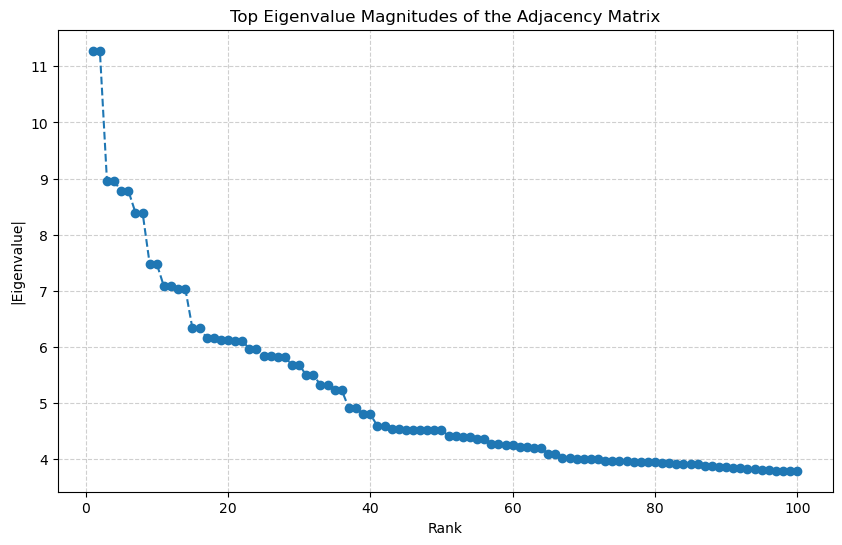


(f) Degree correlations
Degree correlation (Pearson): 0.19187515164844188


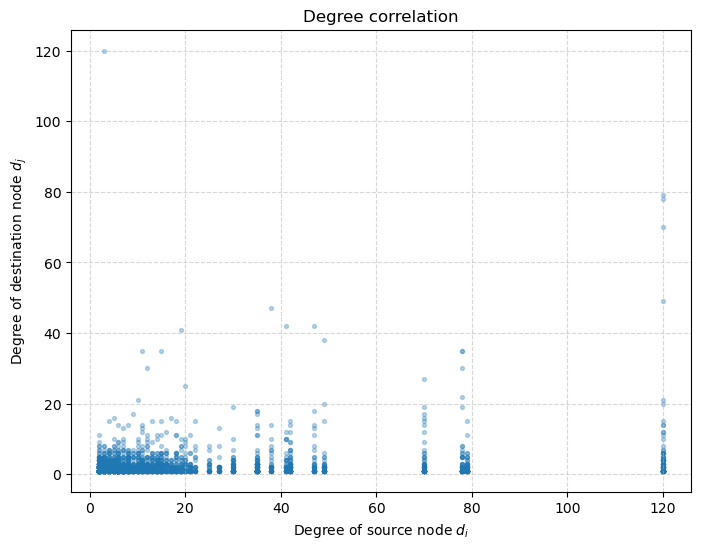


(g) Degree vs clustering coefficient


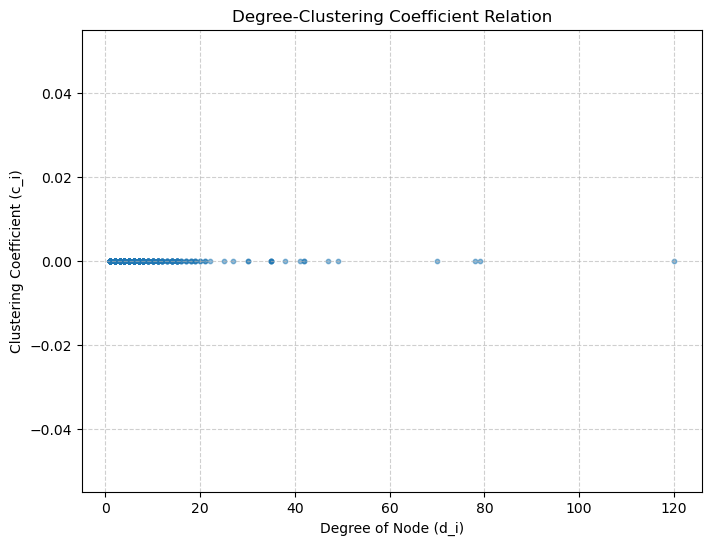

In [ ]:

def analyze_graph_all_parts(adj_matrix, label):
    print("\n" + "=" * 70)
    print(label)

    # (a)
    metrics = metrics(adj_matrix)
    print("\n(a) Graph metrics")
    for k, v in metrics.items():
        print(f"{k}: {v}")

    n = int(metrics["Number of Nodes"])

    # choose sampling rates for large graphs
    sp_frac = 0.001 if n >= 50000 else 0.01
    cc_frac = 0.001 if n >= 50000 else 0.02

    # (b)
    print("\n(b) Degree distribution + power-law fit")
    degree_values, degree_counts = degree_dist(adj_matrix)
    slope, intercept = fit_power_law(degree_values, degree_counts, kmin=1)
    print(f"Slope (log count vs log k): {slope:.4f}")
    degree_dist_plot(degree_values, degree_counts, slope, intercept)

    # (c)
    print("\n(c) Shortest path length distribution (sampled)")
    path_lengths, avg_sp = shortest_paths_dist(adj_matrix, sample_fraction=sp_frac, seed=0)
    print(f"Average shortest path length (reachable pairs only, sampled): {avg_sp:.4f}")
    shortest_paths_dist_bar(path_lengths)

    # (d)
    print("\n(d) Clustering coefficient distribution (sampled)")
    coeffs, avg_c = compute_local_clustering(adj_matrix, sample_fraction=cc_frac)
    print(f"Average clustering coefficient (sampled): {avg_c:.4f}")
    clustering_dist_bar(coeffs, bins=30)

    # (e)
    print("\n(e) Eigenvalue spectrum + spectral gap")
    eigvals_abs, spectral_gap = eigenvalues(adj_matrix, num_eigenvalues=100)
    print(f"Spectral gap (|λ1| - |λ2|): {spectral_gap:.6f}")
    eigenvalues_plot(eigvals_abs)

    # (f)
    print("\n(f) Degree correlations")
    degrees_f = np.array(adj_matrix.sum(axis=1)).flatten()
    pairs, corr = degree_corr(adj_matrix, degrees_f)
    print(f"Degree correlation (Pearson): {corr}")
    degree_corr_plot(pairs)

    # (g)
    print("\n(g) Degree vs clustering coefficient")
    degrees_g = np.array(adj_matrix.sum(axis=1)).flatten()
    clustering_coeffs = clustering_coeffs(adj_matrix)
    degree_clustering_relation(degrees_g, clustering_coeffs)



def estimate_m_from_edges(n, e):
    return max(1, int(round(e / max(1, n))))


def generate_ab_graph(n, m, seed=0):
    if n <= 1: return csc_matrix((n, n))
    if m < 1: m = 1
    if m >= n: m = n - 1

    np.random.seed(seed)
    edges = []

    if m == 1:
        edges.append((0, 1))
        degrees = [1, 1]
        start_node = 2
    else:
        for i in range(m):
            for j in range(i + 1, m):
                edges.append((i, j))
        degrees = [m - 1] * m
        start_node = m

    for new_node in range(start_node, n):
        targets = []
        target_set = set()

        while len(targets) < m:
            total_deg = sum(degrees)
            if total_deg == 0:
                raise ValueError("Degree sum is zero. Preferential attachment is not possible.")

            rand_node = np.random.choice(len(degrees), p=np.array(degrees) / total_deg)
            if rand_node not in target_set:
                targets.append(rand_node)
                target_set.add(rand_node)

        for target in targets:
            edges.append((new_node, target))
            degrees[target] += 1

        degrees.append(m)

    edge_array = np.array(edges)
    adj = csc_matrix((np.ones(len(edges)), (edge_array[:, 0], edge_array[:, 1])), shape=(n, n))
    adj = adj + adj.T
    adj.setdiag(0)
    adj.eliminate_zeros()
    if adj.nnz:
        adj.data[:] = 1

    return adj


datasets = [
    ("Metabolic", "data/metabolic.edgelist.txt"),
    ("Internet", "data/internet.edgelist.txt"),
    ("Power Grid", "data/powergrid.edgelist.txt"),
]

for i, (name, path) in enumerate(datasets):
    print("\n" + "#" * 70)
    print(f"DATASET: {name} ({path})")

    # real graph
    edges = load_edge_list(path)
    A_real = undirected_adj(edges)
    real_metrics = metrics(A_real)
    n = int(real_metrics["Number of Nodes"])
    e = int(real_metrics["Number of Edges"])
    m = estimate_m_from_edges(n, e)

    analyze_graph_all_parts(A_real, f"{name} REAL")

    A_ba = generate_ab_graph(n, m, seed=100 + i)
    analyze_graph_all_parts(A_ba, f"{name} BA SYNTHETIC (n={n}, m={m})")